In [1]:
!pip install -q kaggle
from google.colab import drive
drive.mount("/content/drive")

!mkdir ~/.kaggle #코랩 노트북 안에 kaggle이라는 폴더를 만든것임
## Drive에 kaggle.json을 업로드한 경로를 적으시면 됩니다. ex) (/content/drive/MyDrive/study_session/kaggle.json)
!cp /content/drive/MyDrive/DSL_2023-2_실전데이터사이언스방법론/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [2]:
# 공모전 이름
competition_name = "titanic"

# 공모전 다운로드 to local environment
! kaggle competitions download -c {competition_name}

# {competition_name}이름의 폴더에 zip 파일 압축해제
! unzip {competition_name + ".zip"} -d {competition_name}

# 드라이브 확인을 완료했으므로 드라이브 mount를 해제합니다.
drive.flush_and_unmount()

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 53.2MB/s]
Archive:  titanic.zip
  inflating: titanic/gender_submission.csv  
  inflating: titanic/test.csv        
  inflating: titanic/train.csv       


In [3]:
import numpy as np
import pandas as pd

train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

In [4]:

from sklearn.model_selection import train_test_split

X = train.drop(columns = ['PassengerId', 'Survived'], axis = 1)
y = train['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 77, stratify = y)

In [5]:
## GPU 활성화
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 데이터임베딩 방법

In [6]:
train_labels = [int(_) for _ in y_train.values] ## [0,1,1, ...]
texts_1 = [", ".join(str(_)) for _ in X_train.values]
texts_2 = [str(_) for _ in X_train.values]

def make_sentence(dataframe, i): #i means index
  Pclass=str(dataframe.iloc[i,0])
  Name=str(dataframe.iloc[i,1])
  Sex=str(dataframe.iloc[i,2])
  Age=str(dataframe.iloc[i,3])
  SibSp=str(dataframe.iloc[i,4])
  Parch=str(dataframe.iloc[i,5])
  Ticket=str(dataframe.iloc[i,6])
  Fare=str(dataframe.iloc[i,7])
  Cabin=str(dataframe.iloc[i,8])
  Embarked=str(dataframe.iloc[i,9])

  sentence=("This passenger's Pclass is {0}. The name is {1}. The sex is {2} and is {3} years old. It has {4} siblings or spouse aboard "
          "and {5} parents or children aboard. The ticket number is {6}, and the fare paid was {7}. It stayed in cabin {8}, "
          "and its port of embarkation was {9}.".format(Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked))
  return sentence

texts_3 = [make_sentence(X_train, i) for i in range(len(X_train))]

In [7]:
print(texts_1[0])
print(texts_2[0])
print(texts_3[0])

[, 2,  , ', B, e, a, n, e, ,,  , M, r, .,  , E, d, w, a, r, d, ',  , ', m, a, l, e, ',  , 3, 2, ., 0,  , 1,  , 0,  , ', 2, 9, 0, 8, ',  , 2, 6, ., 0,  , n, a, n,  , ', S, ', ]
[2 'Beane, Mr. Edward' 'male' 32.0 1 0 '2908' 26.0 nan 'S']
This passenger's Pclass is 2. The name is Beane, Mr. Edward. The sex is male and is 32.0 years old. It has 1 siblings or spouse aboard and 0 parents or children aboard. The ticket number is 2908, and the fare paid was 26.0. It stayed in cabin nan, and its port of embarkation was S.


In [8]:
answer = [int(_) for _ in y_val.values]
val_texts_1 = [", ".join(str(_)) for _ in X_val.values]
val_texts_2 = [str(_) for _ in X_val.values]
val_texts_3 = [make_sentence(X_val, i) for i in range(len(X_val))]

In [9]:
print(val_texts_1[0])
print(val_texts_2[0])
print(val_texts_3[0])

[, 3,  , ', K, e, a, n, e, ,,  , M, r, .,  , A, n, d, r, e, w,  , ", A, n, d, y, ", ',  , ', m, a, l, e, ',  , n, a, n,  , 0,  , 0,  , ', 1, 2, 4, 6, 0, ',  , 7, ., 7, 5,  , n, a, n,  , ', Q, ', ]
[3 'Keane, Mr. Andrew "Andy"' 'male' nan 0 0 '12460' 7.75 nan 'Q']
This passenger's Pclass is 3. The name is Keane, Mr. Andrew "Andy". The sex is male and is nan years old. It has 0 siblings or spouse aboard and 0 parents or children aboard. The ticket number is 12460, and the fare paid was 7.75. It stayed in cabin nan, and its port of embarkation was Q.


### 다양한 벡터
- word_mean_vector
- pooler_vector

In [10]:
from typing import List
from tqdm.notebook import tqdm

!pip install -q transformers
from transformers import AutoModel, AutoTokenizer

class Encode_with_BERT_word_mean_vector:
    def __init__(self):
        ## Huggingface에서 BERT 모델을 받아옵니다.
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.model = AutoModel.from_pretrained('bert-base-uncased').to(device)

    ## 입력한 `texts`을 768 길이의 숫자벡터로 특징을 추출합니다.
    def extract(self, texts: List[str]):
        features = np.zeros((len(texts), 768), dtype = np.float16)
        for index, text in enumerate(tqdm(texts)):
            tokenized_text = self.tokenizer(text, return_tensors="pt").to(device)
            model_output = self.model(**tokenized_text)[0].detach().cpu()
            features[index, :] = model_output.numpy().mean(axis=1)

        return features

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.1 MB/s eta 0:00:00


In [11]:
class Encode_with_BERT_cls_vector:
    def __init__(self):
        ## Huggingface에서 BERT 모델을 받아옵니다.
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.model = AutoModel.from_pretrained('bert-base-uncased').to(device)

    ## 입력한 `texts`을 768 길이의 숫자벡터로 특징을 추출합니다.
    def extract(self, texts: List[str]):
        features = np.zeros((len(texts), 768), dtype = np.float16)
        for index, text in enumerate(tqdm(texts)):
            tokenized_text = self.tokenizer(text, return_tensors="pt").to(device)
            model_output = self.model(**tokenized_text)[1].detach().cpu()
            features[index, :] = model_output.numpy()

        return features

### Compare

In [12]:
### texts_1
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

extractor_word = Encode_with_BERT_word_mean_vector()
extractor_cls = Encode_with_BERT_cls_vector()

scaler_word = StandardScaler()
scaler_cls = StandardScaler()

classifier_word = XGBClassifier(use_label_encoder = False)
classifier_cls = XGBClassifier(use_label_encoder = False)

train_features_word = scaler_word.fit_transform(extractor_word.extract(texts_1)) ## to (len(texts), 768) 숫자벡터
train_features_cls = scaler_cls.fit_transform(extractor_cls.extract(texts_1))

classifier_word.fit(train_features_word, train_labels)
classifier_cls.fit(train_features_cls, train_labels)

preds_word = classifier_word.predict(scaler_word.transform(extractor_word.extract(val_texts_1)))
preds_cls = classifier_cls.predict(scaler_cls.transform(extractor_cls.extract(val_texts_1)))

accuracy_word = accuracy_score(answer, preds_word)
accuracy_cls = accuracy_score(answer, preds_cls)
print(accuracy_word, accuracy_cls) #word 평균 > cls

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predict

  0%|          | 0/712 [00:00<?, ?it/s]

  0%|          | 0/712 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

0.8044692737430168 0.7318435754189944


In [13]:
### texts_2
extractor_word = Encode_with_BERT_word_mean_vector()
extractor_cls = Encode_with_BERT_cls_vector()

scaler_word = StandardScaler()
scaler_cls = StandardScaler()

classifier_word = XGBClassifier(use_label_encoder = False)
classifier_cls = XGBClassifier(use_label_encoder = False)

train_features_word = scaler_word.fit_transform(extractor_word.extract(texts_2)) ## to (len(texts), 768) 숫자벡터
train_features_cls = scaler_cls.fit_transform(extractor_cls.extract(texts_2))

classifier_word.fit(train_features_word, train_labels)
classifier_cls.fit(train_features_cls, train_labels)

preds_word = classifier_word.predict(scaler_word.transform(extractor_word.extract(val_texts_2)))
preds_cls = classifier_cls.predict(scaler_cls.transform(extractor_cls.extract(val_texts_2)))

accuracy_word = accuracy_score(answer, preds_word)
accuracy_cls = accuracy_score(answer, preds_cls)
print(accuracy_word, accuracy_cls) #word 평균 < cls

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predict

  0%|          | 0/712 [00:00<?, ?it/s]

  0%|          | 0/712 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

0.7932960893854749 0.8100558659217877


In [14]:
### texts_3
extractor_word = Encode_with_BERT_word_mean_vector()
extractor_cls = Encode_with_BERT_cls_vector()

scaler_word = StandardScaler()
scaler_cls = StandardScaler()

classifier_word = XGBClassifier(use_label_encoder = False)
classifier_cls = XGBClassifier(use_label_encoder = False)

train_features_word = scaler_word.fit_transform(extractor_word.extract(texts_3)) ## to (len(texts), 768) 숫자벡터
train_features_cls = scaler_cls.fit_transform(extractor_cls.extract(texts_3))

classifier_word.fit(train_features_word, train_labels)
classifier_cls.fit(train_features_cls, train_labels)

preds_word = classifier_word.predict(scaler_word.transform(extractor_word.extract(val_texts_3)))
preds_cls = classifier_cls.predict(scaler_cls.transform(extractor_cls.extract(val_texts_3)))

accuracy_word = accuracy_score(answer, preds_word)
accuracy_cls = accuracy_score(answer, preds_cls)
print(accuracy_word, accuracy_cls) #word 평균 > cls

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predict

  0%|          | 0/712 [00:00<?, ?it/s]

  0%|          | 0/712 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

0.8491620111731844 0.7541899441340782


### 차원축소도 해보자
- texts_3 가지고

In [15]:
train_features_word = scaler_word.fit_transform(extractor_word.extract(texts_3))
train_features_word

  0%|          | 0/712 [00:00<?, ?it/s]

array([[-0.6807 ,  0.0489 , -0.1686 , ...,  1.383  ,  0.4893 , -0.352  ],
       [ 0.1558 ,  0.791  , -0.774  , ..., -1.274  ,  0.301  , -0.284  ],
       [-0.3818 ,  0.2468 , -0.3657 , ...,  1.044  , -0.06946,  0.659  ],
       ...,
       [-1.518  , -1.888  , -0.2056 , ...,  1.348  , -0.2234 ,  0.941  ],
       [-0.9897 , -0.817  ,  0.521  , ..., -0.625  ,  1.378  ,  0.868  ],
       [-1.079  ,  0.913  , -2.312  , ..., -1.533  ,  0.4893 , -1.526  ]],
      dtype=float16)

In [16]:
train_features_word.shape #지금 보면 데이터개수보다 차원이 더 높잖아 차원축소하자

(712, 768)

In [18]:
from sklearn.decomposition import PCA
pca=PCA(n_components=712)
X_train_PCA=pca.fit_transform(train_features_word)
X_train_PCA.shape

(712, 712)

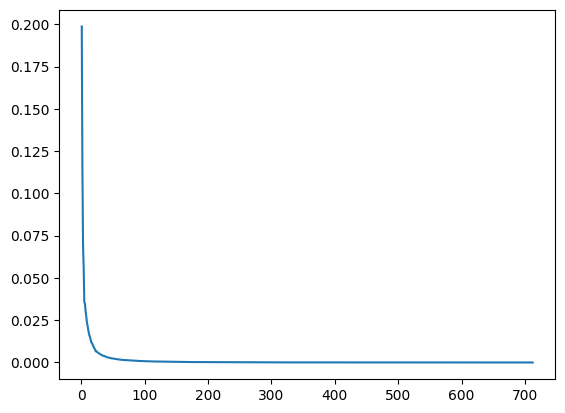

In [21]:
import matplotlib.pyplot as plt
plt.plot(range(1,713),pca.explained_variance_ratio_)
plt.show()

In [22]:
for i in [10,20,50,100,712]:
  explained=np.sum(pca.explained_variance_ratio_[:i])
  print(i,'개의 잠재변수가 설명하는 분산은 전체 데이터의 {:.2f}%'.format(explained*100))

10 개의 잠재변수가 설명하는 분산은 전체 데이터의 61.48%
20 개의 잠재변수가 설명하는 분산은 전체 데이터의 74.95%
50 개의 잠재변수가 설명하는 분산은 전체 데이터의 87.82%
100 개의 잠재변수가 설명하는 분산은 전체 데이터의 94.40%
712 개의 잠재변수가 설명하는 분산은 전체 데이터의 100.00%


In [24]:
cumulative = []
temp = 0
for i in range(0, 712):
    temp += pca.explained_variance_ratio_[i]
    cumulative.append(temp)

cumulative=np.array(cumulative)
np.where(cumulative>0.8)[0][0] #27개 쓰면 분산의 80%이상 설명 가능

27

In [28]:
X_train_PCA[:,:27].shape

(712, 27)

In [29]:
classifier_word = XGBClassifier(use_label_encoder = False)
classifier_word.fit(X_train_PCA[:,:27], train_labels)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [30]:
#val
X_val_PCA=pca.transform(scaler_word.transform(extractor_word.extract(val_texts_3)))
X_val_PCA.shape

  0%|          | 0/179 [00:00<?, ?it/s]

(179, 712)

In [31]:
preds_word = classifier_word.predict(X_val_PCA[:,:27])
accuracy_word = accuracy_score(answer, preds_word)
print(accuracy_word)

0.8212290502793296
